In [306]:

import shap 
import os 
import numpy as np
import pandas as pd 
import math  
import eli5
from eli5.sklearn import PermutationImportance
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 

# These are the modules for orthogonal matrixes
from scipy.stats import ortho_group
import numpy.linalg as lin 
import seaborn as sns 
from numpy.linalg import qr

# These are the modules for the classification 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import recall_score, accuracy_score,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
import shap 
import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder


## 1) Reading Data Files

In [307]:

First_dataSet = pd.read_csv("../datasets/processed.cleveland.csv")
First_dataSet.columns = ['age', 'sex', 'Chest_pain_type', 'Resting_blood_pressure', 'Cholesterol', 'Fasting_blood_sugar','Resting_electrocardiogram', 'Max_heart_rate_achieved', 'Exercise_induced_angina', 'St_depression', 'St_slope', 'Num_major_vessels', 'Thalassemia', 'num' ]
print(First_dataSet.shape)
First_dataSet.head()


(302, 14)


,age,sex,Chest_pain_type,Resting_blood_pressure,Cholesterol,Fasting_blood_sugar,Resting_electrocardiogram,Max_heart_rate_achieved,Exercise_induced_angina,St_depression,St_slope,Num_major_vessels,Thalassemia,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0



## 2) Main Data Perprocessing 
### Replacing The Question Marks

In [308]:
First_dataSet = First_dataSet.replace('?',np.NaN)
# print(Main_dataSet)
number_of_nan_count = First_dataSet.isnull().sum()
print(number_of_nan_count)

age                          0
sex                          0
Chest_pain_type              0
Resting_blood_pressure       0
Cholesterol                  0
Fasting_blood_sugar          0
Resting_electrocardiogram    0
Max_heart_rate_achieved      0
Exercise_induced_angina      0
St_depression                0
St_slope                     0
Num_major_vessels            4
Thalassemia                  2
num                          0
dtype: int64


## 2-1) Replace the NaN values in the Main Dataset

In [309]:

# Num_major_vessels 
avg_Num_major_vessels  = First_dataSet["Num_major_vessels"].astype('float').mean(axis=0)
avg_Num_major_vessels  = math.ceil(avg_Num_major_vessels )
First_dataSet["Num_major_vessels"].replace(np.nan, avg_Num_major_vessels , inplace=True)   
print("Average of number of major vessels is:", avg_Num_major_vessels)  


avg_Thalassemia = First_dataSet["Thalassemia"].astype('float').mean(axis=0)
avg_Thalassemia = math.ceil(avg_Thalassemia)
First_dataSet["Thalassemia"].replace(np.nan, avg_Thalassemia, inplace=True)   
print("Average of Thalassemia:", avg_Thalassemia)  



Average of number of major vessels is: 1
Average of Thalassemia: 5


### 2_2 ) Checking if the DataFrame is all cleaned up

In [310]:

number_of_nan_count_1 = First_dataSet.isnull().sum()
print(number_of_nan_count_1)


age                          0
sex                          0
Chest_pain_type              0
Resting_blood_pressure       0
Cholesterol                  0
Fasting_blood_sugar          0
Resting_electrocardiogram    0
Max_heart_rate_achieved      0
Exercise_induced_angina      0
St_depression                0
St_slope                     0
Num_major_vessels            0
Thalassemia                  0
num                          0
dtype: int64


## 3) Main data Set info

In [311]:

First_dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        302 non-null    float64
 1   sex                        302 non-null    float64
 2   Chest_pain_type            302 non-null    float64
 3   Resting_blood_pressure     302 non-null    float64
 4   Cholesterol                302 non-null    float64
 5   Fasting_blood_sugar        302 non-null    float64
 6   Resting_electrocardiogram  302 non-null    float64
 7   Max_heart_rate_achieved    302 non-null    float64
 8   Exercise_induced_angina    302 non-null    float64
 9   St_depression              302 non-null    float64
 10  St_slope                   302 non-null    float64
 11  Num_major_vessels          302 non-null    object 
 12  Thalassemia                302 non-null    object 
 13  num                        302 non-null    int64  

## 4) Selecting the Categorical Features 

In [312]:
categorical_features = ["sex", "age","Chest_pain_type", "Resting_blood_pressure", "Cholesterol", "Fasting_blood_sugar", "Resting_electrocardiogram", "Max_heart_rate_achieved", "Exercise_induced_angina" , "St_depression", "St_slope", "Num_major_vessels"]


## 5) Coverting the Type 'object' into 'int'

In [313]:

string_columns = First_dataSet.select_dtypes(include="object").columns

First_dataSet[string_columns]=First_dataSet[string_columns].astype('float')

float_columns = First_dataSet.select_dtypes(include="float64").columns

First_dataSet[float_columns]= First_dataSet[float_columns].astype('int')

First_dataSet.dtypes


age                          int32
sex                          int32
Chest_pain_type              int32
Resting_blood_pressure       int32
Cholesterol                  int32
Fasting_blood_sugar          int32
Resting_electrocardiogram    int32
Max_heart_rate_achieved      int32
Exercise_induced_angina      int32
St_depression                int32
St_slope                     int32
Num_major_vessels            int32
Thalassemia                  int32
num                          int64
dtype: object

## 6) Description of Main data set after conversions

In [314]:
First_dataSet.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.410596,9.040163,29.0,48.00,55.5,61.0,77.0
sex,302.0,0.678808,0.467709,0.0,0.00,1.0,1.0,1.0
Chest_pain_type,302.0,3.165563,0.953612,1.0,3.00,3.0,4.0,4.0
Resting_blood_pressure,302.0,131.645695,17.612202,94.0,120.00,130.0,140.0,200.0
Cholesterol,302.0,246.738411,51.856829,126.0,211.00,241.5,275.0,564.0
Fasting_blood_sugar,302.0,0.145695,0.353386,0.0,0.00,0.0,0.0,1.0
Resting_electrocardiogram,302.0,0.986755,0.994916,0.0,0.00,0.5,2.0,2.0
Max_heart_rate_achieved,302.0,149.605960,22.912959,71.0,133.25,153.0,166.0,202.0
Exercise_induced_angina,302.0,0.327815,0.470196,0.0,0.00,0.0,1.0,1.0
St_depression,302.0,0.761589,1.070341,0.0,0.00,0.0,1.0,6.0


## 7 ) Visually Checking the Distribution of the different categories of data

In [315]:




# With this function we want to check the Distribution of the data

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()

    # Here we want to pick a column that have at least 1 and 500 unique values
    df = df[[ col for col in df if nunique[col] > 1 and nunique[col] < 500 ]]

    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = round((nCol + nGraphPerRow) - 1 / nGraphPerRow)
    plt.figure( num = None, figsize = ( 6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]

        if( not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()

        plt.ylabel('counts')
        plt.xticks(rotation = 90)  
        plt.title(f'{columnNames[i]} (columns{i})') 
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)  
    plt.show() 
    


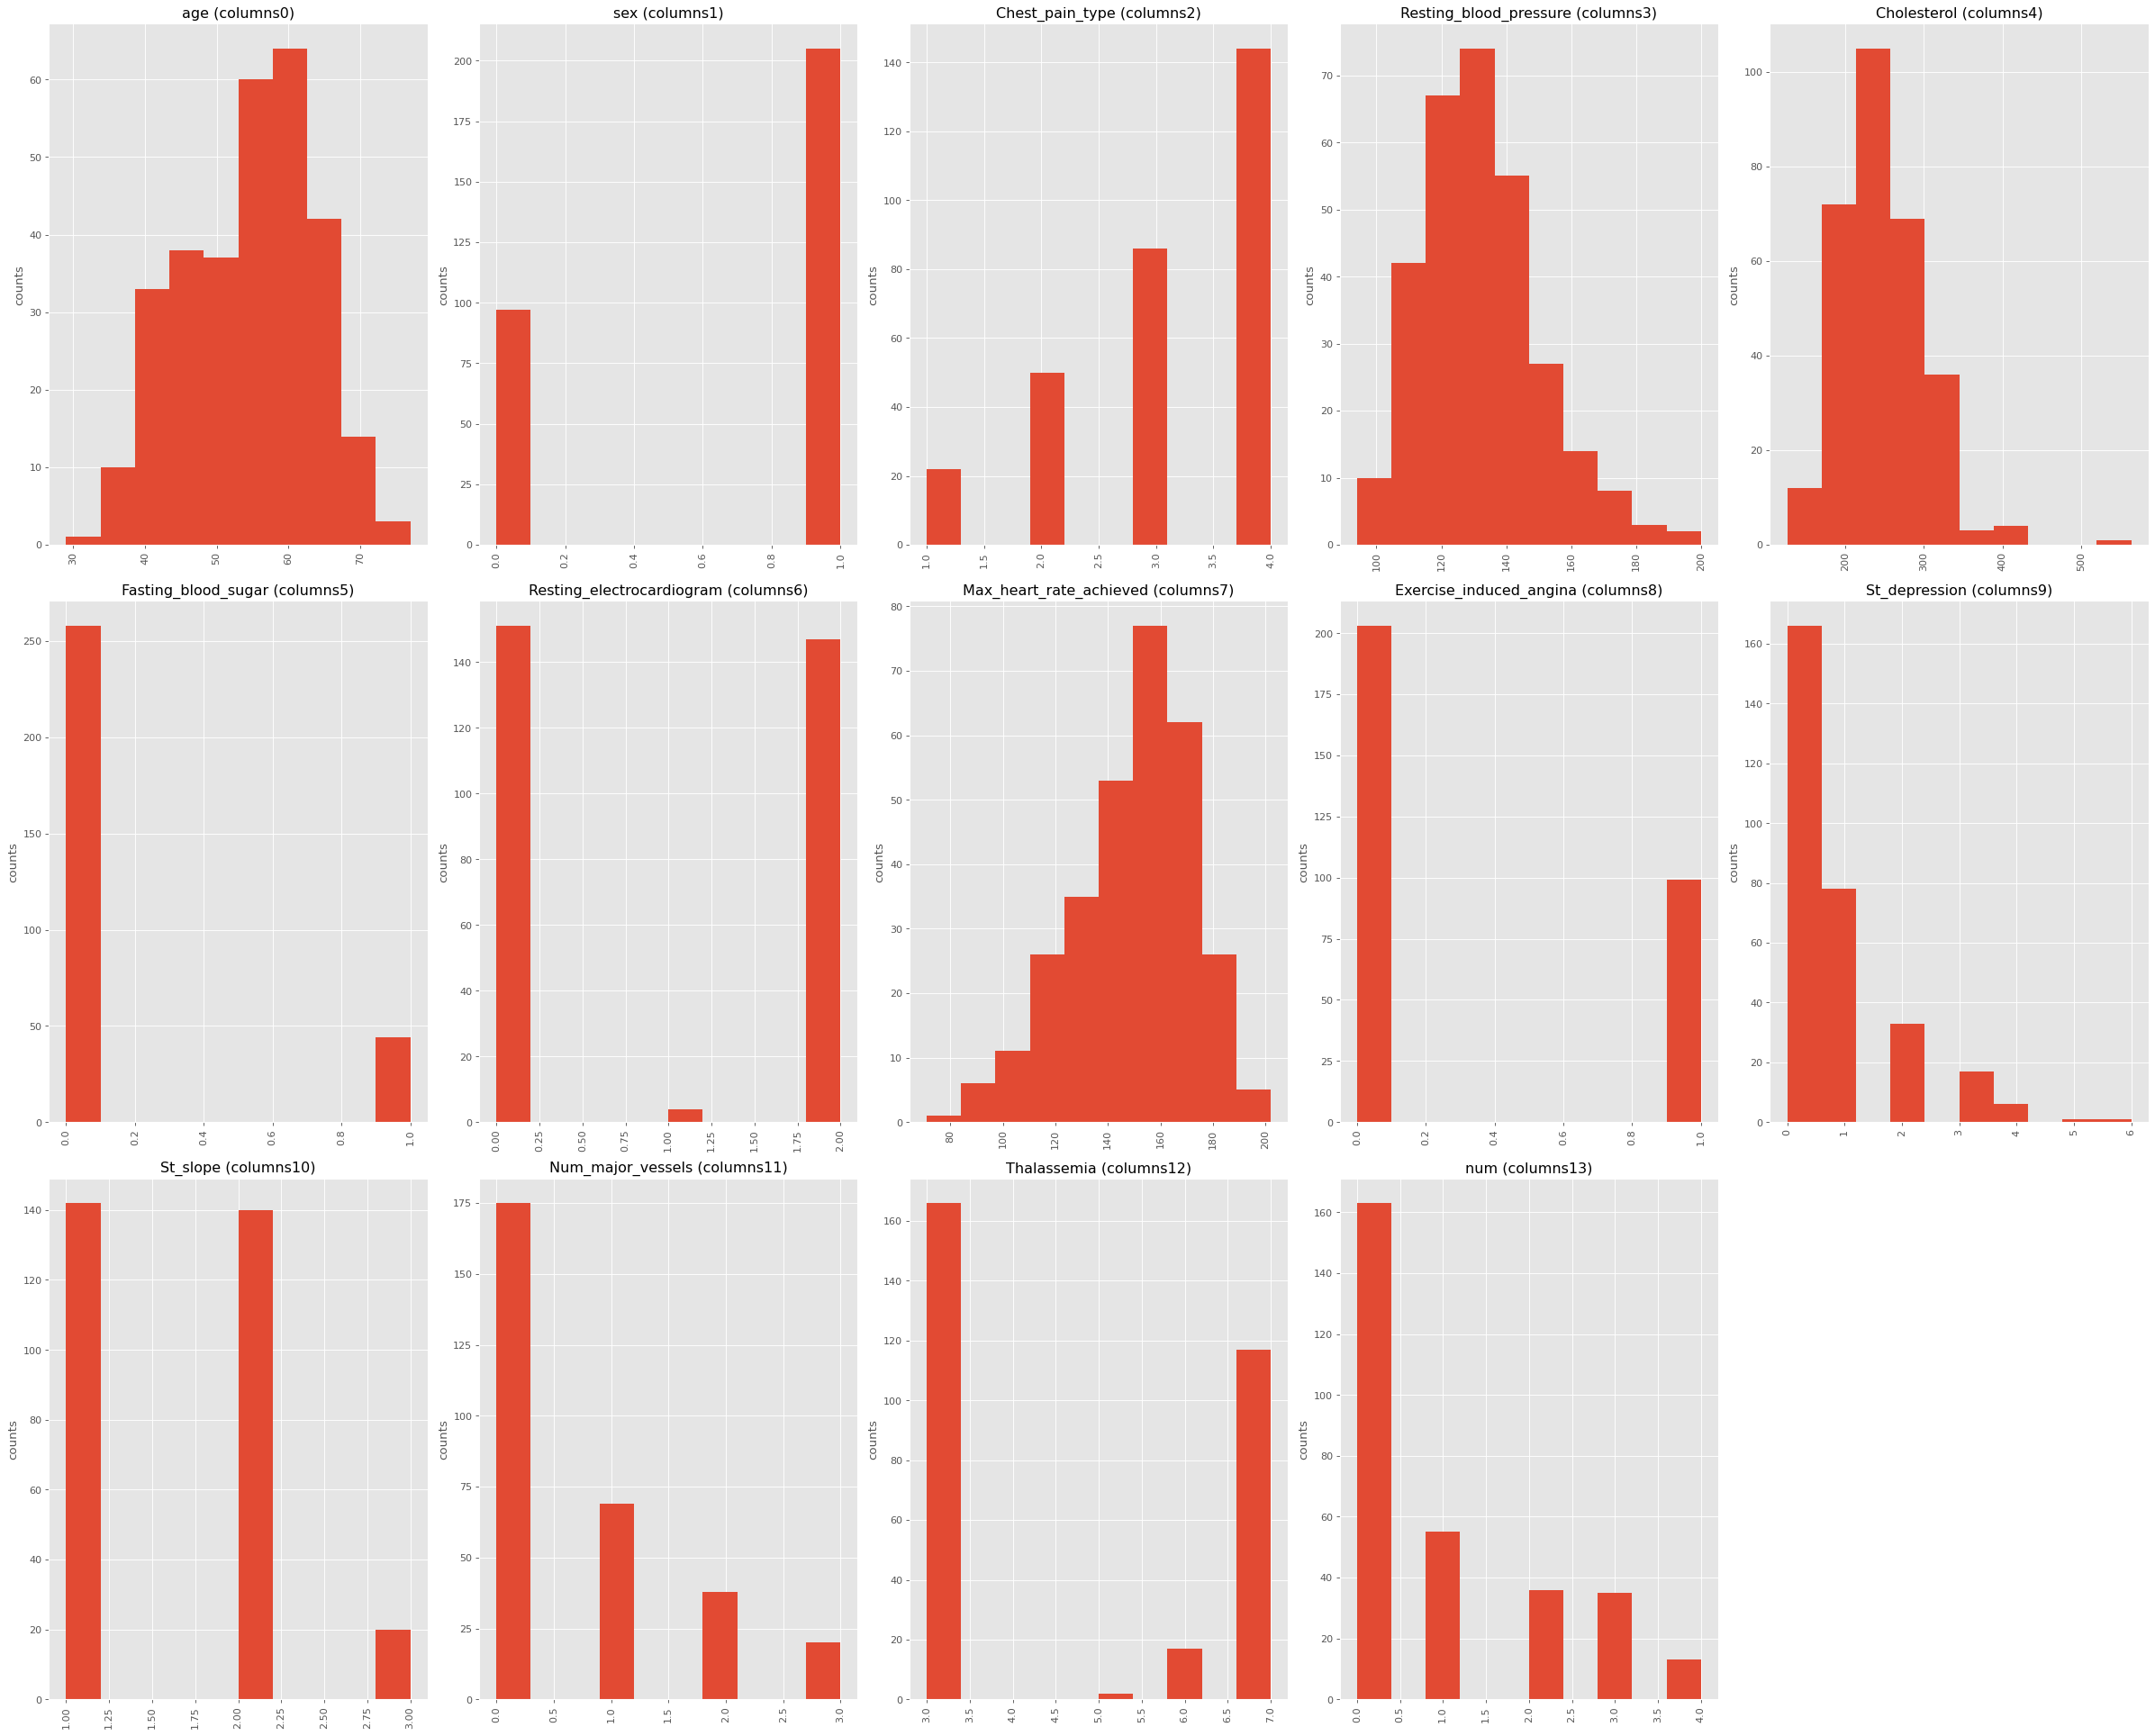

In [316]:


Main_dataFrame = First_dataSet.astype({"Chest_pain_type":"int32", "Resting_blood_pressure":"int32", "Cholesterol":"int32","Fasting_blood_sugar":"int32","Resting_electrocardiogram":"int32", "Max_heart_rate_achieved":"int32", "Exercise_induced_angina":"int32", "St_depression":"int32", "St_slope": "int32", "Num_major_vessels":"int32", "Thalassemia": "int32",  "num": "int32" })
plotPerColumnDistribution(Main_dataFrame, 35, 5)


## 8) Feature Exploration and Feature Selection
### Function for Finding Correlated Features 

In [317]:


# Distribution graphs of the column data
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName

    # Keep the columns with more than 1 unique values
    df = df[[col for col in df if df[col].nunique() > 0 ]]

    if df.shape[1] < 0:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({ df.shape[1]}) is less than 2')
        return
    corr = df.corr()  
    plt.figure(num = None, figsize =(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)  
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)




In [318]:


Main_dataFrame.dataframeName = 'HeartDiseases.csv'
nRow, nCol = Main_dataSet.shape
print(f'There are {nRow} rows and {nCol} columns')


There are 717 rows and 14 columns


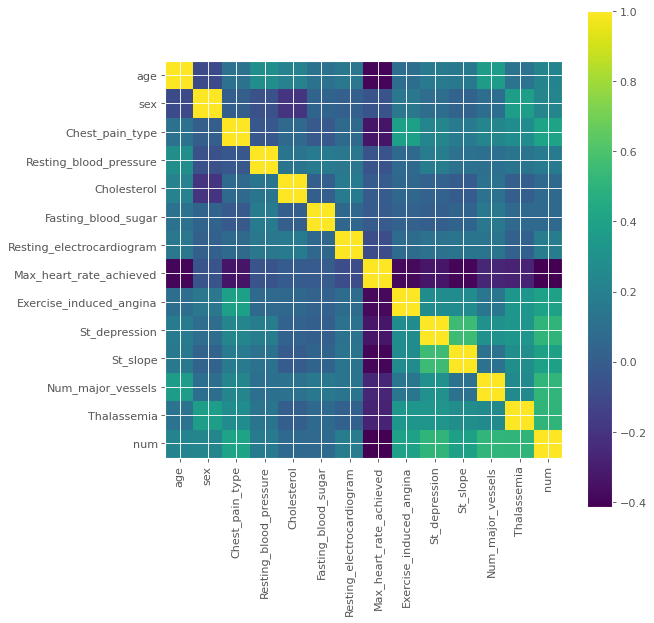

In [319]:
plotCorrelationMatrix(Main_dataFrame, 8)

## 9) Description of the Catgorical Features 

In [320]:

Main_dataFrame[categorical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
sex,302.0,0.678808,0.467709,0.0,0.00,1.0,1.0,1.0
age,302.0,54.410596,9.040163,29.0,48.00,55.5,61.0,77.0
Chest_pain_type,302.0,3.165563,0.953612,1.0,3.00,3.0,4.0,4.0
Resting_blood_pressure,302.0,131.645695,17.612202,94.0,120.00,130.0,140.0,200.0
Cholesterol,302.0,246.738411,51.856829,126.0,211.00,241.5,275.0,564.0
Fasting_blood_sugar,302.0,0.145695,0.353386,0.0,0.00,0.0,0.0,1.0
Resting_electrocardiogram,302.0,0.986755,0.994916,0.0,0.00,0.5,2.0,2.0
Max_heart_rate_achieved,302.0,149.605960,22.912959,71.0,133.25,153.0,166.0,202.0
Exercise_induced_angina,302.0,0.327815,0.470196,0.0,0.00,0.0,1.0,1.0
St_depression,302.0,0.761589,1.070341,0.0,0.00,0.0,1.0,6.0


## 9_1 ) Distribution of categorical features

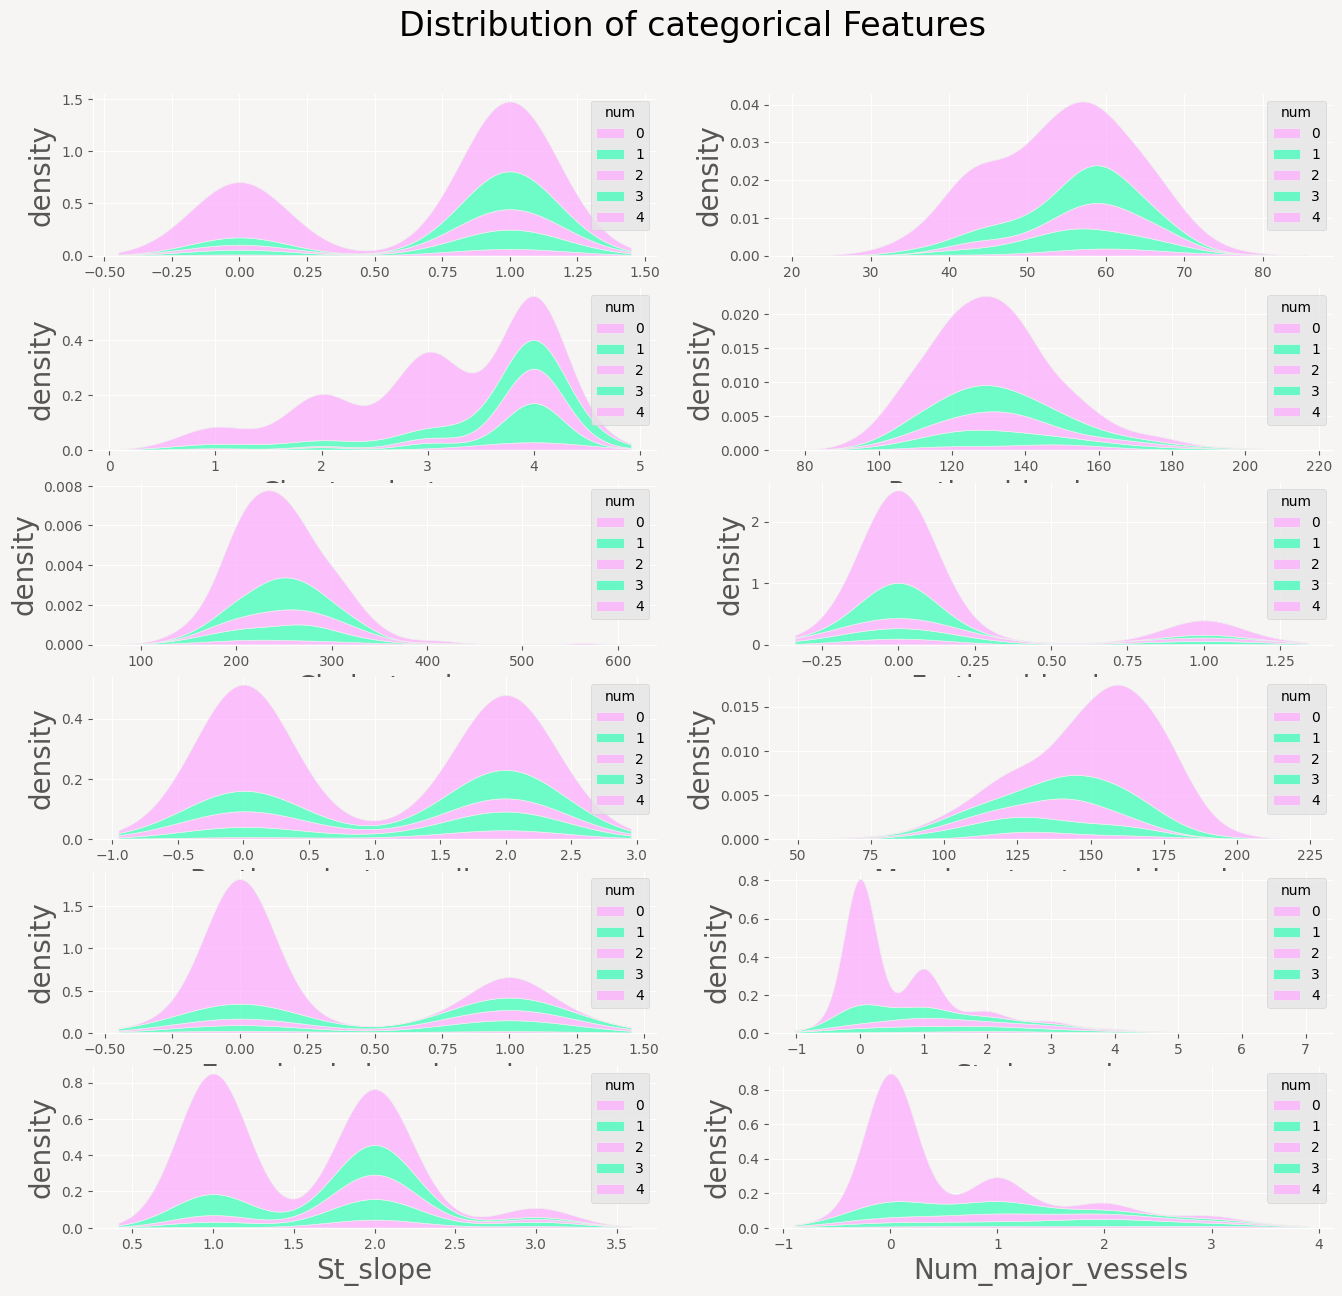

In [321]:



mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

L = len(categorical_features)
ncol = 2
nrow = int(np.ceil(L/ncol))

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)

i = 1
for col in categorical_features:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
    
    ax = sns.kdeplot(data=Main_dataFrame, x=col, hue="num", multiple="stack", palette=mypal[1::4]) 
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)
    
    if col == 'num_major_vessels':
        sns.countplot(data=Main_dataFrame, x=col, hue="num", palette=mypal[1::4])
        for p in ax.patches:
                height = p.get_height() 
                ax.text(p.get_x()+p.get_width()/2.,height,'{:1.0f}'.format((height)),ha="center", fontsize = 5,
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
    
    i = i +1
plt.suptitle('Distribution of categorical Features' ,fontsize = 24);




### 9_2) Shows the Distribution of Heart Diseases with respect to Male and Female Gender

In [322]:

fig=px.histogram(Main_dataSet, 
                 x="Thalassemia",
                 color="sex",
                 hover_data=Main_dataSet.columns,
                 title="Distribution of Thalassemia as a Heart Diseases",
                 barmode="group")
fig.show()

## 9_3) the Distribution of the number of major vessels 

In [323]:
fig=px.histogram(Main_dataSet,
                 x="Num_major_vessels",
                 color="sex",
                 hover_data=Main_dataSet.columns,
                 title="Number of Major Vessels"
                )
fig.show()

## 9_4 ) The Distribution of Categorical Values in Numbers

In [324]:

integer_col = Main_dataSet.select_dtypes('int').columns.to_list()

Main_dataSet[integer_col].head()
for col in integer_col:
    print(f"The distribution of categorical values in the {col} is : ")
    print(Main_dataSet[col].value_counts())

The distribution of categorical values in the age is : 
54    44
52    34
58    31
56    29
51    28
57    28
53    28
55    27
59    27
48    27
50    23
43    23
46    22
41    22
60    20
49    20
62    20
47    19
61    19
44    18
45    17
42    17
38    15
65    15
39    15
63    14
64    13
40    11
35    10
67    10
37    10
66    10
34     7
70     6
36     6
68     6
69     5
32     4
71     3
29     3
31     2
33     2
74     2
30     1
76     1
77     1
72     1
73     1
Name: age, dtype: int64
The distribution of categorical values in the sex is : 
1    529
0    188
Name: sex, dtype: int64
The distribution of categorical values in the Chest_pain_type is : 
4    365
2    159
3    157
1     36
Name: Chest_pain_type, dtype: int64
The distribution of categorical values in the Resting_blood_pressure is : 
120    115
130     99
140     92
110     50
150     47
160     42
125     27
115     19
135     17
145     15
100     14
138     13
128     13
132     12
112     12
180     10

## 9_5) Plots For The Distribution of all the Categorical Values 

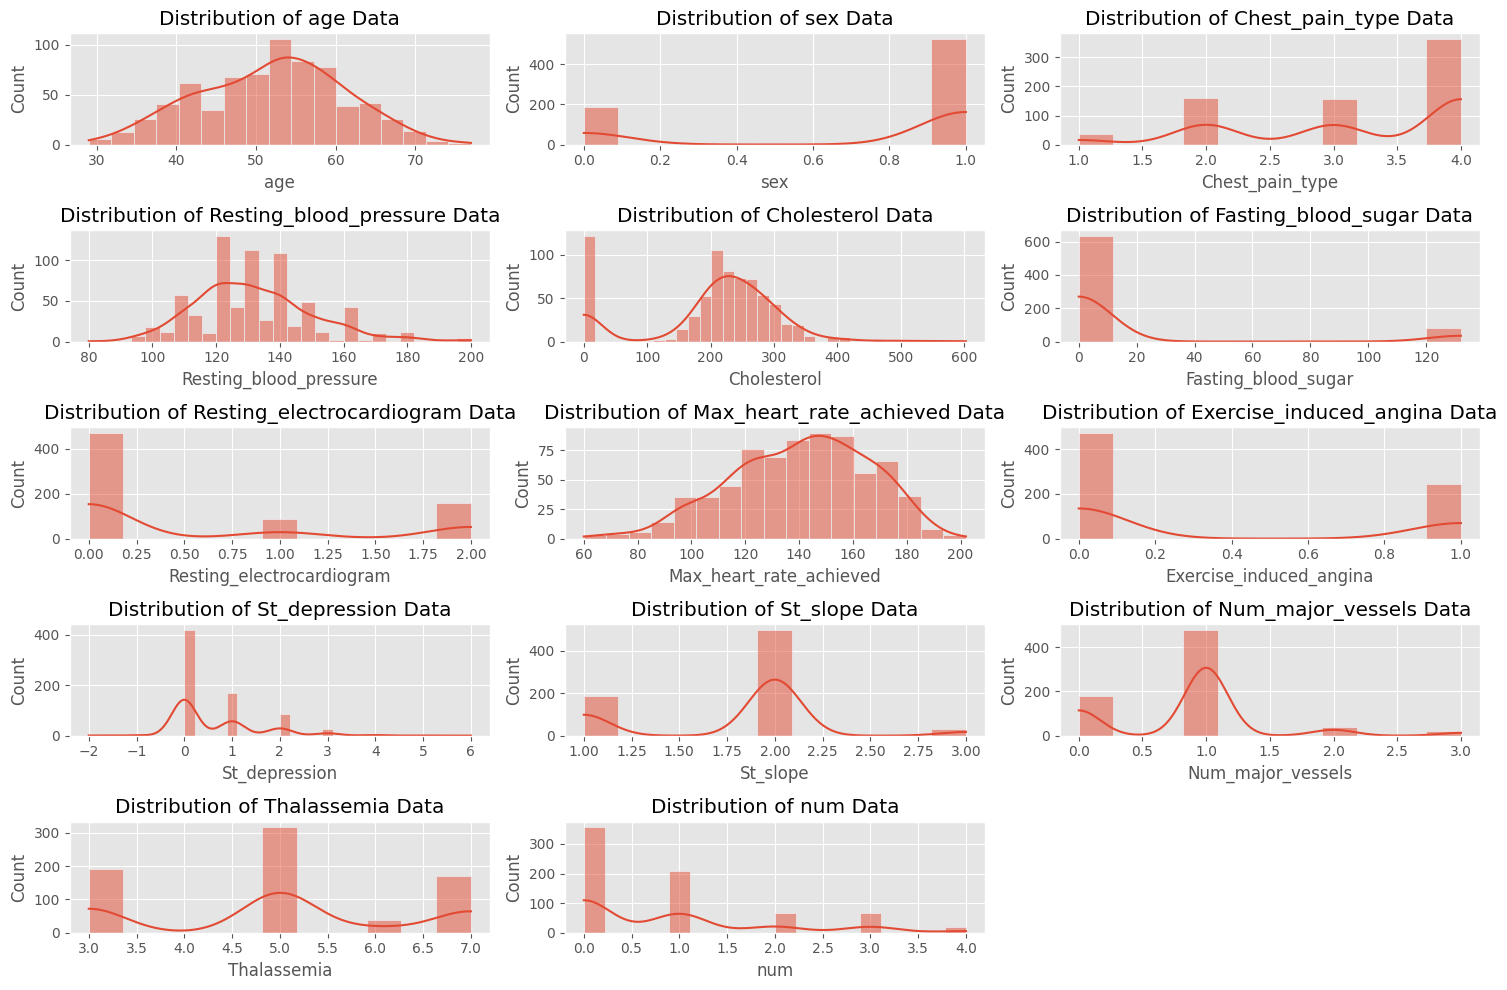

In [325]:

plt.figure(figsize=(15,10))
for i,col in enumerate(Main_dataSet.columns,1):
    plt.subplot(5,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(Main_dataSet[col],kde=True)
    plt.tight_layout()
    plt.plot()

# 10 ) Spiting the Main Date set into train and test

In [326]:

X = First_dataSet.drop(['Thalassemia', 'num'], axis=1)
y = First_dataSet['Thalassemia']

# Split the data into training and validation sets
Main_train_X, Main_test_X, Main_train_y, Main_test_y = train_test_split(X, y, random_state=7)
print(Main_train_X.shape)
print(Main_train_y.shape)
print(Main_test_X.shape)
print(Main_test_y.shape)
print(type(Main_train_X))
Main_train_y.dtypes

(226, 12)
(226,)
(76, 12)
(76,)
<class 'pandas.core.frame.DataFrame'>


dtype('int32')

## 11 ) The Main Evaluation Model

In [327]:

from sklearn.metrics import  accuracy_score, confusion_matrix, classification_report 

def print_score(clf, X_train, y_train, X_test, y_test, train = True): 
    if train : 
        pred = clf.predict(X_train)
        experiment_classification_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%") 
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{experiment_classification_report}")
        print("_______________________________________________") 
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n") 
    elif train == False:
        pred = clf.predict(X_test)
        experiment_classification_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{experiment_classification_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


## 12 ) Encodng the labels for the categorical Features

In [328]:
# this function encode the categorical features into numbers, it lowers the variance 

def label_encode_cat_features(data, cat_features):
    
    label_encoder = LabelEncoder()
    data_encoded = data.copy()
    
    for col in cat_features:
        data_encoded[col] = label_encoder.fit_transform(data[col])
    
    data = data_encoded
    
    return data

In [329]:
data = label_encode_cat_features(First_dataSet, categorical_features)


In [330]:
features = data.columns[:-1]
type(features)

X = data[features]
y = data['Thalassemia']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7)


# Classifications
### 11_1 ) K-Nearest Neighbors classification on the Main data set

In [331]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

y_prediction = knn.predict(X_val)

y_prediction

array([3, 3, 7, 3, 7, 7, 3, 3, 7, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 7, 7,
       3, 7, 3, 3, 3, 7, 7, 3, 3, 7, 3, 3, 3, 7, 3, 3, 3, 7, 3, 3, 3, 7,
       3, 7, 3, 3, 3, 7, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 7, 7, 7, 3, 3,
       3, 3, 7, 7, 7, 3, 3, 7, 3, 3])

In [332]:

print_score(knn, X_train, y_train, X_val, y_val, train=True)
print_score(knn, X_train, y_train,  X_val, y_val, train=False)


Train Result:
Accuracy Score: 80.97%
_______________________________________________
CLASSIFICATION REPORT:
                    3    5          6          7  accuracy   macro avg  \
precision    0.791667  0.0   1.000000   0.833333  0.809735    0.656250   
recall       0.904762  0.0   0.363636   0.738636  0.809735    0.501759   
f1-score     0.844444  0.0   0.533333   0.783133  0.809735    0.540228   
support    126.000000  1.0  11.000000  88.000000  0.809735  226.000000   

           weighted avg  
precision      0.814528  
recall         0.809735  
f1-score       0.801692  
support      226.000000  
_______________________________________________
Confusion Matrix: 
 [[114   0   0  12]
 [  1   0   0   0]
 [  6   0   4   1]
 [ 23   0   0  65]]

Test Result:
Accuracy Score: 64.47%
_______________________________________________
CLASSIFICATION REPORT:
                   3    5    6          7  accuracy  macro avg  weighted avg
precision   0.680000  0.0  0.0   0.576923  0.644737   0.31423

# 12 ) The Decomposition of the DataFrames

### 12-1) First, QR Decomposition on the Main dataset

In [383]:
First_QR_array = First_dataSet.to_numpy(dtype=float)
Q, R = qr(First_QR_array)
Q_1, R_1 = np.linalg.qr(First_QR_array)

Q_1 = Q_1.round(2)
R_1 = R_1.round(2)


print(Q)
print(Q_1.shape)
print(R_1.shape)

[[-0.06990272 -0.02297176 -0.00692408 ... -0.12619151  0.14514743
  -0.03674683]
 [-0.06990272 -0.02297176 -0.00692408 ... -0.03965757 -0.02851388
  -0.11414352]
 [-0.038603   -0.0652217  -0.04039956 ...  0.01539805  0.09890269
  -0.06165984]
 ...
 [-0.05946948 -0.03705507 -0.03688509 ... -0.01301261 -0.03274096
   0.07357971]
 [-0.05946948  0.0802749   0.05796266 ... -0.06345222  0.00194531
   0.05428844]
 [-0.03964632 -0.06381337 -0.03740346 ... -0.07216533  0.05881157
  -0.03076401]]
(302, 14)
(14, 14)


## 13 ) Feature scaling and lowering the QR data variance

In [384]:
Q_with_lower_variance = 20 * np.array(Q_1)
print(Q_with_lower_variance)

# Converting into integr - we should use non-continuous data for classifications
Q_with_lower_variance = np.int64(Q_with_lower_variance)
Q_with_lower_variance.dtype

[[-1.4 -0.4 -0.2 ... -2.6  3.  -0.8]
 [-1.4 -0.4 -0.2 ... -0.8 -0.6 -2.2]
 [-0.8 -1.4 -0.8 ...  0.4  2.  -1.2]
 ...
 [-1.2 -0.8 -0.8 ... -0.2 -0.6  1.4]
 [-1.2  1.6  1.2 ... -1.2  0.   1. ]
 [-0.8 -1.2 -0.8 ... -1.4  1.2 -0.6]]


dtype('int64')

## 12-2 ) Convert The First Decomposed QR array into dataFrame

In [385]:

# convert decomposed QR array to dataFrame

First_Q_decomposition_dataFrame = pd.DataFrame(Q_with_lower_variance, columns = ['age', 'sex', 'Chest_pain_type', 'Resting_blood_pressure', 'Cholesterol', 'Fasting_blood_sugar','Resting_electrocardiogram', 'Max_heart_rate_achieved', 'Exercise_induced_angina', 'St_depression', 'St_slope', 'Num_major_vessels', 'Thalassemia', 'num' ])
First_Q_decomposition_dataFrame.head()


,age,sex,Chest_pain_type,Resting_blood_pressure,Cholesterol,Fasting_blood_sugar,Resting_electrocardiogram,Max_heart_rate_achieved,Exercise_induced_angina,St_depression,St_slope,Num_major_vessels,Thalassemia,num
0,-1,0,0,0,0,0,1,2,0,-1,0,-2,3,0
1,-1,0,0,2,0,0,1,0,-1,0,0,0,0,-2
2,0,-1,0,-1,-1,0,-1,-1,0,3,-2,0,2,-1
3,0,1,0,-2,0,0,1,-1,0,1,1,0,0,0
4,-1,0,1,0,0,0,-1,-1,0,0,0,0,0,0


In [335]:
# dataFrame data type conversion

'''
float_columns = First_Q_decomposition_dataFrame.select_dtypes(include="float64").columns

First_Q_decomposition_dataFrame[float_columns]=First_Q_decomposition_dataFrame[float_columns].astype('int')

First_Q_decomposition_dataFrame.dtypes
'''


age                          int32
sex                          int32
Chest_pain_type              int32
Resting_blood_pressure       int32
Cholesterol                  int32
Fasting_blood_sugar          int32
Resting_electrocardiogram    int32
Max_heart_rate_achieved      int32
Exercise_induced_angina      int32
St_depression                int32
St_slope                     int32
Num_major_vessels            int32
Thalassemia                  int32
num                          int32
dtype: object

## 12_3 ) Spiliting into train and test and label encoding the data
### QR Decomposition

In [386]:
decomposition_data = label_encode_cat_features(First_Q_decomposition_dataFrame, categorical_features)

features_1 = decomposition_data.columns[:-1]
type(features_1)

X = decomposition_data[features_1]
y = decomposition_data['Thalassemia']

X_train_QR_decomposition, X_val_QR_decomposition, y_train_QR_decomposition, y_val_QR_decomposition = train_test_split(X, y, random_state=7)



## 11-2 ) K-Nearest Neighbors classification 
### The first QR decomposition

In [387]:
knn_deco = KNeighborsClassifier(n_neighbors=3)

knn_deco.fit(X_train_QR_decomposition, y_train_QR_decomposition)

y_prediction_deco = knn.predict(X_train_QR_decomposition)


## Model Evaluation for the QR Decomposition

In [388]:
print_score(knn_deco, X_train_QR_decomposition, y_train_QR_decomposition, X_val_QR_decomposition, y_val_QR_decomposition, train=True)
print_score(knn_deco, X_train_QR_decomposition, y_train_QR_decomposition,  X_val_QR_decomposition, y_val_QR_decomposition, train=False)

Train Result:
Accuracy Score: 89.82%
_______________________________________________
CLASSIFICATION REPORT:
                 -2         -1           0          1         2    3  \
precision  0.700000   0.936170    0.903509   0.900000  0.800000  0.0   
recall     0.875000   0.862745    0.971698   0.865385  0.500000  0.0   
f1-score   0.777778   0.897959    0.936364   0.882353  0.615385  0.0   
support    8.000000  51.000000  106.000000  52.000000  8.000000  1.0   

           accuracy   macro avg  weighted avg  
precision   0.89823    0.706613      0.895206  
recall      0.89823    0.679138      0.898230  
f1-score    0.89823    0.684973      0.894151  
support     0.89823  226.000000    226.000000  
_______________________________________________
Confusion Matrix: 
 [[  7   1   0   0   0   0]
 [  3  44   3   1   0   0]
 [  0   1 103   2   0   0]
 [  0   1   6  45   0   0]
 [  0   0   2   2   4   0]
 [  0   0   0   0   1   0]]

Test Result:
Accuracy Score: 64.47%
_______________________

## 13 ) Gram Schmit Decomposition
### Second Decomposition

In [389]:

First_gramschmit_array = Main_dataSet.to_numpy(dtype=float)

def gramschmidt(A):
    """
    Applies the Gram-Schmidt method to A
    and returns Q and R, so Q*R = A.
    """
    R = np.zeros((A.shape[1], A.shape[1]))
    Q = np.zeros(A.shape)
    for k in range(0, A.shape[1]):
        R[k, k] = np.sqrt(np.dot(A[:, k], A[:, k]))
        Q[:, k] = A[:, k]/R[k, k]
        for j in range(k+1, A.shape[1]):
            R[k, j] = np.dot(Q[:, k], A[:, j])
            A[:, j] = A[:, j] - R[k, j]*Q[:, k]
    return Q, R

gramschmidt_Q_1, gramschmidt_R_1 = gramschmidt(First_gramschmit_array)

gramschmidt_Q_1 = gramschmidt_Q_1.round(2)
gramschmidt_R_1 = gramschmidt_R_1.round(2)


print(gramschmidt_Q_1.shape)
print(gramschmidt_R_1.shape)
print(gramschmidt_Q_1)



(717, 14)
(14, 14)
[[ 0.05  0.01 -0.   ...  0.11 -0.1  -0.  ]
 [ 0.05  0.01 -0.   ...  0.06  0.03 -0.08]
 [ 0.03  0.04  0.02 ... -0.06 -0.07 -0.01]
 ...
 [ 0.05  0.   -0.05 ...  0.04 -0.03 -0.11]
 [ 0.05 -0.08 -0.03 ...  0.01 -0.04 -0.01]
 [ 0.05 -0.   -0.09 ... -0.01  0.01 -0.03]]


## 13_1 ) Feature Scaling and The Normalization of the Gram Schmidt Data

In [439]:
gramschmidt_Q_2 = 8*np.array(gramschmidt_Q_1)
# print(gramschmidt_Q_2)
gramschmidt_Q_2 = np.int64(gramschmidt_Q_2)
gramschmidt_Q_2.dtype

dtype('int64')

### 13_2 ) Converting the First Gram Schmit Decomposition array into a dataFrame

In [398]:

First_Gramschmidt_dataFrame = pd.DataFrame(gramschmidt_Q_2, columns = ['age', 'sex', 'Chest_pain_type', 'Resting_blood_pressure', 'Cholesterol', 'Fasting_blood_sugar','Resting_electrocardiogram', 'Max_heart_rate_achieved', 'Exercise_induced_angina', 'St_depression', 'St_slope', 'Num_major_vessels', 'Thalassemia', 'num' ])
First_Gramschmidt_dataFrame.head()



,age,sex,Chest_pain_type,Resting_blood_pressure,Cholesterol,Fasting_blood_sugar,Resting_electrocardiogram,Max_heart_rate_achieved,Exercise_induced_angina,St_depression,St_slope,Num_major_vessels,Thalassemia,num
0,0,0,0,0,0,0,4032,-4032,0,0,0,4032,-4032,0
1,0,0,0,-4032,0,0,0,0,0,0,0,4032,0,-4032
2,0,0,0,0,0,0,0,4032,0,8064,4032,-4032,-4032,0
3,0,0,0,0,0,0,4032,0,0,0,0,0,0,0
4,0,0,-4032,0,0,0,0,0,0,0,0,0,0,0


# 11_3 ) KKN for Gram schmidt Decompoition 

In [259]:
#data_3 = label_encode_cat_features(First_Gramschmidt_dataFrame, categorical_features)

In [408]:

X = First_Gramschmidt_dataFrame.drop(['Thalassemia'], axis=1)
y = First_Gramschmidt_dataFrame['Thalassemia']


First_Gramschmidt_X_train, First_Gramschmidt_X_val, First_Gramschmidt_y_train, First_Gramschmidt_y_val = train_test_split(X, y, random_state=1)

type(First_Gramschmidt_X_train)



pandas.core.frame.DataFrame

In [400]:

knn_Gramschmidt_deco = KNeighborsClassifier(n_neighbors=3)

knn_Gramschmidt_deco.fit(First_Gramschmidt_X_train,First_Gramschmidt_y_train)

y_prediction_Gramschmidt_deco = knn.predict(First_Gramschmidt_X_val)


In [401]:

print_score(knn_Gramschmidt_deco, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=True)
print_score(knn_Gramschmidt_deco, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=False)



Train Result:
Accuracy Score: 86.22%
_______________________________________________
CLASSIFICATION REPORT:
               -4032           0       4032  accuracy   macro avg  \
precision   0.500000    0.872832   1.000000  0.862197    0.790944   
recall      0.205128    0.991247   0.048780  0.862197    0.415052   
f1-score    0.290909    0.928279   0.093023  0.862197    0.437404   
support    39.000000  457.000000  41.000000  0.862197  537.000000   

           weighted avg  
precision      0.855464  
recall         0.862197  
f1-score       0.818217  
support      537.000000  
_______________________________________________
Confusion Matrix: 
 [[  8  31   0]
 [  4 453   0]
 [  4  35   2]]

Test Result:
Accuracy Score: 80.56%
_______________________________________________
CLASSIFICATION REPORT:
           -4032           0  4032  accuracy   macro avg  weighted avg
precision    0.0    0.819209   0.0  0.805556    0.273070      0.669021
recall       0.0    0.986395   0.0  0.805556    0.32

## 14-1 ) Random Forest Classification
### On Main Data Set

In [402]:

Random_Forest_classification_Main_dataset = RandomForestClassifier(random_state=0)
Random_Forest_classification_Main_dataset.fit(X_train, y_train)
Random_Forest_classification_Main_dataset_prediction = Random_Forest_classification_Main_dataset.predict(X_val)


In [403]:
print_score(Random_Forest_classification_Main_dataset, X_train, y_train, X_val, y_val, train=True)
print_score(Random_Forest_classification_Main_dataset, X_train, y_train,  X_val, y_val, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               3    5     6     7  accuracy  macro avg  weighted avg
precision    1.0  1.0   1.0   1.0       1.0        1.0           1.0
recall       1.0  1.0   1.0   1.0       1.0        1.0           1.0
f1-score     1.0  1.0   1.0   1.0       1.0        1.0           1.0
support    126.0  1.0  11.0  88.0       1.0      226.0         226.0
_______________________________________________
Confusion Matrix: 
 [[126   0   0   0]
 [  0   1   0   0]
 [  0   0  11   0]
 [  0   0   0  88]]

Test Result:
Accuracy Score: 94.74%
_______________________________________________
CLASSIFICATION REPORT:
                   3    5         6         7  accuracy  macro avg  \
precision   0.975610  0.0  1.000000   0.90625  0.947368   0.720465   
recall      1.000000  0.0  0.500000   1.00000  0.947368   0.625000   
f1-score    0.987654  0.0  0.666667   0.95082  0.947368   0.651285   
support    40

## 14_2 )Random Forest Classification
### On QR decomposition

In [404]:

Random_Forest_classification_QR_Decomposition = RandomForestClassifier(random_state=0)
Random_Forest_classification_QR_Decomposition.fit(X_train_QR_decomposition, y_train_QR_decomposition)
Random_Forest_classification_QR_Decomposition_prediction = Random_Forest_classification_QR_Decomposition.predict(X_val_QR_decomposition)



In [405]:

print_score(Random_Forest_classification_QR_Decomposition, X_train_QR_decomposition, y_train_QR_decomposition, X_val_QR_decomposition, y_val_QR_decomposition, train=True)
print_score(Random_Forest_classification_QR_Decomposition, X_train_QR_decomposition, y_train_QR_decomposition,  X_val_QR_decomposition, y_val_QR_decomposition, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
            -2    -1      0     1    2    3  accuracy  macro avg  weighted avg
precision  1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
recall     1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
f1-score   1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
support    8.0  51.0  106.0  52.0  8.0  1.0       1.0      226.0         226.0
_______________________________________________
Confusion Matrix: 
 [[  8   0   0   0   0   0]
 [  0  51   0   0   0   0]
 [  0   0 106   0   0   0]
 [  0   0   0  52   0   0]
 [  0   0   0   0   8   0]
 [  0   0   0   0   0   1]]

Test Result:
Accuracy Score: 94.74%
_______________________________________________
CLASSIFICATION REPORT:
                 -2         -1     0          1         2  accuracy  \
precision  1.000000   0.900000   1.0   0.875000  1.000000  0.947368   
recall     0.33

## 14_3 ) Random Forest Classification
### Gram schmidt Decompoition 

In [406]:

Random_Forest_classification_Gramschmidt_Decomposition = RandomForestClassifier(random_state=0)
Random_Forest_classification_Gramschmidt_Decomposition.fit(First_Gramschmidt_X_train, First_Gramschmidt_y_train)
Random_Forest_classification_Gramschmidt_Decomposition_prediction = Random_Forest_classification_Gramschmidt_Decomposition.predict(First_Gramschmidt_X_val)



In [407]:


print_score(Random_Forest_classification_Gramschmidt_Decomposition, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=True)
print_score(Random_Forest_classification_Gramschmidt_Decomposition, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=False)



Train Result:
Accuracy Score: 91.81%
_______________________________________________
CLASSIFICATION REPORT:
               -4032           0       4032  accuracy   macro avg  \
precision   0.875000    0.917172   1.000000  0.918063    0.930724   
recall      0.538462    0.993435   0.439024  0.918063    0.656974   
f1-score    0.666667    0.953782   0.610169  0.918063    0.743539   
support    39.000000  457.000000  41.000000  0.918063  537.000000   

           weighted avg  
precision      0.920433  
recall         0.918063  
f1-score       0.906695  
support      537.000000  
_______________________________________________
Confusion Matrix: 
 [[ 21  18   0]
 [  3 454   0]
 [  0  23  18]]

Test Result:
Accuracy Score: 80.00%
_______________________________________________
CLASSIFICATION REPORT:
           -4032           0       4032  accuracy   macro avg  weighted avg
precision    0.0    0.820809   0.333333       0.8    0.384714      0.701809
recall       0.0    0.965986   0.117647   

## 15_1 ) Naive Bayes Classification
### Main dataSet

In [409]:

Naive_Bayes_Classification_Main_dataSet = GaussianNB()
Naive_Bayes_Classification_Main_dataSet.fit(X_train, y_train)
Naive_Bayes_prediction_Main_dataSet = Naive_Bayes_Classification_Main_dataSet.predict( X_val)
Naive_Bayes_prediction_Main_dataSet

array([3, 3, 3, 7, 6, 7, 3, 3, 7, 7, 3, 3, 7, 7, 6, 3, 3, 3, 7, 3, 7, 7,
       3, 7, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 7,
       3, 7, 3, 7, 3, 7, 3, 3, 7, 7, 6, 3, 7, 3, 3, 7, 7, 7, 6, 7, 3, 3,
       7, 7, 7, 6, 7, 7, 6, 6, 3, 3])

In [411]:
print_score(Naive_Bayes_Classification_Main_dataSet, X_train, y_train, X_val, y_val, train=True)
print_score(Naive_Bayes_Classification_Main_dataSet, X_train, y_train,  X_val, y_val, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               3    5     6     7  accuracy  macro avg  weighted avg
precision    1.0  1.0   1.0   1.0       1.0        1.0           1.0
recall       1.0  1.0   1.0   1.0       1.0        1.0           1.0
f1-score     1.0  1.0   1.0   1.0       1.0        1.0           1.0
support    126.0  1.0  11.0  88.0       1.0      226.0         226.0
_______________________________________________
Confusion Matrix: 
 [[126   0   0   0]
 [  0   1   0   0]
 [  0   0  11   0]
 [  0   0   0  88]]

Test Result:
Accuracy Score: 98.68%
_______________________________________________
CLASSIFICATION REPORT:
              3    5         6     7  accuracy  macro avg  weighted avg
precision   1.0  0.0  0.857143   1.0  0.986842   0.714286      0.975564
recall      1.0  0.0  1.000000   1.0  0.986842   0.750000      0.986842
f1-score    1.0  0.0  0.923077   1.0  0.986842   0.730769      0.980769
suppo

## 15_2 ) Naive Bayes Classification
### On QR Decomposition

In [416]:

Naive_Bayes_Classification_QR_Decomposition = GaussianNB()
Naive_Bayes_Classification_QR_Decomposition.fit(X_train_QR_decomposition, y_train_QR_decomposition)
Naive_Bayes_Prediction_QR_Decomposition = Naive_Bayes_Classification_QR_Decomposition.predict(X_val_QR_decomposition)
Naive_Bayes_Prediction_QR_Decomposition


array([ 1,  1,  2, -1, -1,  0,  1,  1,  0, -1,  1,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1, -2,  0,  1,  0,  0,
        0,  2,  2,  0, -1, -1,  0,  1,  0, -2,  0, -1,  1, -1,  1, -2,  0,
        0, -1,  0,  0,  1,  0,  1,  2,  0, -1,  0,  0, -1,  1,  0,  0, -1,
       -1, -1, -1, -1, -1,  0,  1,  0], dtype=int64)

In [417]:

print_score(Naive_Bayes_Classification_QR_Decomposition, X_train_QR_decomposition, y_train_QR_decomposition, X_val_QR_decomposition, y_val_QR_decomposition, train=True)
print_score(Naive_Bayes_Classification_QR_Decomposition, X_train_QR_decomposition, y_train_QR_decomposition,  X_val_QR_decomposition, y_val_QR_decomposition, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
            -2    -1      0     1    2    3  accuracy  macro avg  weighted avg
precision  1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
recall     1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
f1-score   1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
support    8.0  51.0  106.0  52.0  8.0  1.0       1.0      226.0         226.0
_______________________________________________
Confusion Matrix: 
 [[  8   0   0   0   0   0]
 [  0  51   0   0   0   0]
 [  0   0 106   0   0   0]
 [  0   0   0  52   0   0]
 [  0   0   0   0   8   0]
 [  0   0   0   0   0   1]]

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
            -2    -1     0     1    2  accuracy  macro avg  weighted avg
precision  1.0   1.0   1.0   1.0  1.0       1.0        1.0           1.0
recall    

## 15_3 ) Naive Bayes Classification
### On Gram Schmit Decomposition

In [424]:

Naive_Bayes_Classification_GramSchmit_Decomposition = GaussianNB()
Naive_Bayes_Classification_GramSchmit_Decomposition.fit(First_Gramschmidt_X_train, First_Gramschmidt_y_train)
Naive_Bayes_Prediction_GramSchmit_Decomposition = Naive_Bayes_Classification_QR_Decomposition.predict(First_Gramschmidt_X_val)
# Naive_Bayes_Prediction_GramSchmit_Decomposition



In [425]:


print_score(Naive_Bayes_Classification_GramSchmit_Decomposition, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=True)
print_score(Naive_Bayes_Classification_GramSchmit_Decomposition, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=False)



Train Result:
Accuracy Score: 79.14%
_______________________________________________
CLASSIFICATION REPORT:
               -4032           0       4032  accuracy   macro avg  \
precision   0.288889    0.883516   0.270270  0.791434    0.480892   
recall      0.333333    0.879650   0.243902  0.791434    0.485629   
f1-score    0.309524    0.881579   0.256410  0.791434    0.482504   
support    39.000000  457.000000  41.000000  0.791434  537.000000   

           weighted avg  
precision      0.793510  
recall         0.791434  
f1-score       0.792301  
support      537.000000  
_______________________________________________
Confusion Matrix: 
 [[ 13  25   1]
 [ 29 402  26]
 [  3  28  10]]

Test Result:
Accuracy Score: 71.67%
_______________________________________________
CLASSIFICATION REPORT:
               -4032           0       4032  accuracy   macro avg  \
precision   0.076923    0.816993   0.214286  0.716667    0.369401   
recall      0.062500    0.850340   0.176471  0.716667   

## 16_1 ) Decision Tree Classification
### on Main dataSet

In [420]:

Decision_Tree_Main_dataSet = DecisionTreeClassifier(random_state=42)
Decision_Tree_Main_dataSet.fit(X_train, y_train)
Decision_Tree_Prediction_Main_dataSet = Decision_Tree_Main_dataSet.predict( X_val) 


In [421]:

print_score(Decision_Tree_Main_dataSet, X_train, y_train, X_val, y_val, train=True)
print_score(Decision_Tree_Main_dataSet, X_train, y_train,  X_val, y_val, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               3    5     6     7  accuracy  macro avg  weighted avg
precision    1.0  1.0   1.0   1.0       1.0        1.0           1.0
recall       1.0  1.0   1.0   1.0       1.0        1.0           1.0
f1-score     1.0  1.0   1.0   1.0       1.0        1.0           1.0
support    126.0  1.0  11.0  88.0       1.0      226.0         226.0
_______________________________________________
Confusion Matrix: 
 [[126   0   0   0]
 [  0   1   0   0]
 [  0   0  11   0]
 [  0   0   0  88]]

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              3    5    6     7  accuracy  macro avg  weighted avg
precision   1.0  1.0  1.0   1.0       1.0        1.0           1.0
recall      1.0  1.0  1.0   1.0       1.0        1.0           1.0
f1-score    1.0  1.0  1.0   1.0       1.0        1.0           1.0
support    40.0  1.0  6.

## 16_2 ) Decision Tree Classification
### on QR Decomposition

In [422]:

Decision_Tree_QR_Decomposition = DecisionTreeClassifier(random_state=42)
Decision_Tree_QR_Decomposition.fit(X_train_QR_decomposition, y_train_QR_decomposition)
Decision_Tree_Prediction_QR_Decomposition = Decision_Tree_QR_Decomposition.predict(X_val_QR_decomposition)
 

In [423]:

print_score(Decision_Tree_QR_Decomposition , X_train_QR_decomposition, y_train_QR_decomposition, X_val_QR_decomposition, y_val_QR_decomposition, train=True)
print_score(Decision_Tree_QR_Decomposition , X_train_QR_decomposition, y_train_QR_decomposition,  X_val_QR_decomposition, y_val_QR_decomposition, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
            -2    -1      0     1    2    3  accuracy  macro avg  weighted avg
precision  1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
recall     1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
f1-score   1.0   1.0    1.0   1.0  1.0  1.0       1.0        1.0           1.0
support    8.0  51.0  106.0  52.0  8.0  1.0       1.0      226.0         226.0
_______________________________________________
Confusion Matrix: 
 [[  8   0   0   0   0   0]
 [  0  51   0   0   0   0]
 [  0   0 106   0   0   0]
 [  0   0   0  52   0   0]
 [  0   0   0   0   8   0]
 [  0   0   0   0   0   1]]

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
            -2    -1     0     1    2  accuracy  macro avg  weighted avg
precision  1.0   1.0   1.0   1.0  1.0       1.0        1.0           1.0
recall    

## 16_3 ) Decision Tree Classification
### on Gram Schmit Decomposition

In [426]:

Decision_Tree_GramSchmit_Decomposition = DecisionTreeClassifier(random_state=42)
Decision_Tree_GramSchmit_Decomposition.fit(First_Gramschmidt_X_train, First_Gramschmidt_y_train)
Decision_Tree_Prediction_GramSchmit_Decomposition = Decision_Tree_GramSchmit_Decomposition.predict(First_Gramschmidt_X_val)



In [427]:



print_score(Decision_Tree_GramSchmit_Decomposition, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=True)
print_score(Decision_Tree_GramSchmit_Decomposition, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=False)




Train Result:
Accuracy Score: 91.81%
_______________________________________________
CLASSIFICATION REPORT:
               -4032           0       4032  accuracy   macro avg  \
precision   0.764706    0.925773   1.000000  0.918063    0.896826   
recall      0.666667    0.982495   0.439024  0.918063    0.696062   
f1-score    0.712329    0.953291   0.610169  0.918063    0.758596   
support    39.000000  457.000000  41.000000  0.918063  537.000000   

           weighted avg  
precision      0.919743  
recall         0.918063  
f1-score       0.909593  
support      537.000000  
_______________________________________________
Confusion Matrix: 
 [[ 26  13   0]
 [  8 449   0]
 [  0  23  18]]

Test Result:
Accuracy Score: 79.44%
_______________________________________________
CLASSIFICATION REPORT:
               -4032           0       4032  accuracy   macro avg  \
precision   0.166667    0.846626   0.363636  0.794444    0.458976   
recall      0.062500    0.938776   0.235294  0.794444   

## 17-1 ) Support Vector Machines  classification
### On main data Set

In [430]:
from sklearn.svm import SVC

Support_vector_machine_Main_dataSet = SVC() 
Support_vector_machine_Main_dataSet.fit(X_train,y_train)
Support_vector_machine_prediction_Main_dataSet=Support_vector_machine_Main_dataSet.predict(X_val)


In [431]:

print_score(Support_vector_machine_Main_dataSet, X_train, y_train, X_val, y_val, train=True)
print_score(Support_vector_machine_Main_dataSet, X_train, y_train,  X_val, y_val, train=False)


Train Result:
Accuracy Score: 60.18%
_______________________________________________
CLASSIFICATION REPORT:
                    3    5     6          7  accuracy   macro avg  \
precision    0.625000  0.0   0.0   0.534483   0.60177    0.289871   
recall       0.833333  0.0   0.0   0.352273   0.60177    0.296402   
f1-score     0.714286  0.0   0.0   0.424658   0.60177    0.284736   
support    126.000000  1.0  11.0  88.000000   0.60177  226.000000   

           weighted avg  
precision      0.556569  
recall         0.601770  
f1-score       0.563583  
support      226.000000  
_______________________________________________
Confusion Matrix: 
 [[105   0   0  21]
 [  1   0   0   0]
 [  5   0   0   6]
 [ 57   0   0  31]]

Test Result:
Accuracy Score: 57.89%
_______________________________________________
CLASSIFICATION REPORT:
                   3    5    6          7  accuracy  macro avg  weighted avg
precision   0.618182  0.0  0.0   0.476190  0.578947   0.273593      0.507063
recall   

## 17_2 ) Support Vector Machines  classification
### On QR Decomposition

In [432]:

Support_vector_machine_QR_dataSet = SVC() 
Support_vector_machine_QR_dataSet.fit(X_train_QR_decomposition, y_train_QR_decomposition)
Support_vector_machine_prediction_QR_dataSet=Support_vector_machine_Main_dataSet.predict(X_val_QR_decomposition)



In [433]:

print_score(Support_vector_machine_QR_dataSet , X_train_QR_decomposition, y_train_QR_decomposition, X_val_QR_decomposition, y_val_QR_decomposition, train=True)
print_score(Support_vector_machine_QR_dataSet , X_train_QR_decomposition, y_train_QR_decomposition,  X_val_QR_decomposition, y_val_QR_decomposition, train=False)


Train Result:
Accuracy Score: 92.48%
_______________________________________________
CLASSIFICATION REPORT:
            -2         -1      0          1    2    3  accuracy   macro avg  \
precision  0.0   0.864407    1.0   0.852459  0.0  0.0  0.924779    0.452811   
recall     0.0   1.000000    1.0   1.000000  0.0  0.0  0.924779    0.500000   
f1-score   0.0   0.927273    1.0   0.920354  0.0  0.0  0.924779    0.474604   
support    8.0  51.000000  106.0  52.000000  8.0  1.0  0.924779  226.000000   

           weighted avg  
precision      0.860233  
recall         0.924779  
f1-score       0.890041  
support      226.000000  
_______________________________________________
Confusion Matrix: 
 [[  0   8   0   0   0   0]
 [  0  51   0   0   0   0]
 [  0   0 106   0   0   0]
 [  0   0   0  52   0   0]
 [  0   0   0   8   0   0]
 [  0   0   0   1   0   0]]

Test Result:
Accuracy Score: 90.79%
_______________________________________________
CLASSIFICATION REPORT:
            -2         -1  

## 17_3 ) Support Vector Machines  classification
### On Gram Schmit Decomposition

In [434]:

Support_vector_machine_GramSchmit_dataSet = SVC() 
Support_vector_machine_GramSchmit_dataSet.fit(First_Gramschmidt_X_train, First_Gramschmidt_y_train)
Support_vector_machine_prediction_GramSchmit_dataSet = Support_vector_machine_GramSchmit_dataSet.predict(First_Gramschmidt_X_val)



In [435]:



print_score(Support_vector_machine_GramSchmit_dataSet, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=True)
print_score(Support_vector_machine_GramSchmit_dataSet, First_Gramschmidt_X_train, First_Gramschmidt_y_train, First_Gramschmidt_X_val, First_Gramschmidt_y_val, train=False)




Train Result:
Accuracy Score: 86.22%
_______________________________________________
CLASSIFICATION REPORT:
               -4032           0       4032  accuracy   macro avg  \
precision   1.000000    0.860640   1.000000  0.862197    0.953547   
recall      0.102564    1.000000   0.048780  0.862197    0.383782   
f1-score    0.186047    0.925101   0.093023  0.862197    0.401390   
support    39.000000  457.000000  41.000000  0.862197  537.000000   

           weighted avg  
precision      0.881402  
recall         0.862197  
f1-score       0.807898  
support      537.000000  
_______________________________________________
Confusion Matrix: 
 [[  4  35   0]
 [  0 457   0]
 [  0  39   2]]

Test Result:
Accuracy Score: 81.67%
_______________________________________________
CLASSIFICATION REPORT:
           -4032           0  4032  accuracy   macro avg  weighted avg
precision    0.0    0.816667   0.0  0.816667    0.272222      0.666944
recall       0.0    1.000000   0.0  0.816667    0.33

# The End of Experiment